<a href="https://colab.research.google.com/github/juelha/IANNWTF/blob/sabine/homework03_Sabine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import and split the data

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np

# Returns both train and test split separately 
# remember to change train to 100 000 samples and test to 1000


train_ds, test_ds = tfds.load('genomics_ood', split=['train[0:100000]', 'test[0:1000]'], as_supervised=True)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/12 [00:00<?, ? file/s]


Dataset genomics_ood downloaded and prepared to /root/tensorflow_datasets/genomics_ood/0.0.1. Subsequent calls will reuse this data.


In [2]:
# checks and tests

print(len(list(train_ds)))
print(len(list(test_ds)))

ds = train_ds.take(1)  # Only take a single example
for seq, label in ds:
  print(seq, label)

#print(ds_info)
#print(ds)

100000
1000
tf.Tensor(b'AAACTATGTTATATTCACGATGATTAACTTACAAAGGAGTTTCAACTATGAAGATGATAAACAAATTAATCGTTCCGGTAACAGCTAGTGCTTTATTATTAGGCGCTTGTGGCGCTAGTGCCACAGACTCTAAAGAAAATACATTAATTTCTTCTAAAGCTGGAGACGTAACAGTTGCAGATACAATGAAAAAAATCGGTAAAGATCAAATTGCAAATGCATCATTTACTGAAATGTTAAATAAAATTTT', shape=(), dtype=string) tf.Tensor(7, shape=(), dtype=int64)


In [3]:
# Data Preprocessing

# function that converts the string tensor into a usable tensor that contains the one-hot-encoded sequence
def onehotify(seq):
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    seq = tf.strings.regex_replace(seq, key, vocab[key])
  split = tf.strings.bytes_split(seq)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8)
  onehot = tf.one_hot(labels, 4)  # groups nucleotides together, with on-value, off-value 'matrix' with depth of 4 
  onehot = tf.reshape(onehot, (-1,))   # flattens into 1-D
  return onehot

# function that puts it all together
def preprocessing(tensor):
  tensor = tensor.map(lambda seq, label: (onehotify(seq), tf.one_hot(label, 10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  tensor = tensor.cache()
  #shuffle, batch, prefetch
  tensor = tensor.shuffle(1000)
  tensor = tensor.batch(32)
  tensor = tensor.prefetch(20)
  #return preprocessed dataset
  return tensor

# using map call the onehotify function on seq and create a seperate one_hot encoder on labels 
train_dataset = train_ds.apply(preprocessing)
test_dataset = test_ds.apply(preprocessing)


In [ ]:
# more testing
for seq, label in train_dataset: 
  print('seq=', seq, 'label=', label)
  break

In [9]:
# Model
'''
Implement a simple fully connected feed forward neural network. 
• Hidden layer 1: 256 units. With sigmoid activation function.
• Hidden layer 2: 256 units. With sigmoid activation function.
• Output: 10 units. With softmax activation function.

'''
from tensorflow.keras.layers import Dense

class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.sigmoid)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.sigmoid)
        self.dense3 = tf.keras.layers.Dense(128, activation=tf.sigmoid)
        self.dense4 = tf.keras.layers.Dense(128, activation=tf.sigmoid)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.out(x)
        return x


In [6]:
# Prepare the training loop by providing functionality for training and testing:

'''
For the training loop you can use the ”Complete Model Training” notebook on Courseware as orientation or try to build one yourself.
For this task, an accuracy of 35 - 40% is sufficient
'''

def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [10]:
# Put everything together

'''
Then train your network for 10 epochs using a learning rate of 0.1. As a loss use the
categorical cross entropy. As an optimizer use SGD.
'''

tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
#train_dataset = train_dataset.take(1000)
#test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Train Losses: {train_loss}, Test Losses: {test_loss}')

Epoch: 0 starting with accuracy 0.0966796875
Train Losses: 2.2866830825805664, Test Losses: 2.30780029296875
Epoch: 1 starting with accuracy 0.0888671875
Train Losses: 2.1708388328552246, Test Losses: 2.1412010192871094
Epoch: 2 starting with accuracy 0.173828125
Train Losses: 1.6006107330322266, Test Losses: 1.534214735031128
Epoch: 3 starting with accuracy 0.3037109375
Train Losses: 1.5548536777496338, Test Losses: 1.5091893672943115
Epoch: 4 starting with accuracy 0.3291015625
Train Losses: 1.4783837795257568, Test Losses: 1.51133394241333
Epoch: 5 starting with accuracy 0.3251953125
Train Losses: 1.3861279487609863, Test Losses: 1.4866695404052734
Epoch: 6 starting with accuracy 0.349609375
Train Losses: 1.5371193885803223, Test Losses: 1.474853515625
Epoch: 7 starting with accuracy 0.37890625
Train Losses: 1.472945213317871, Test Losses: 1.4880430698394775
Epoch: 8 starting with accuracy 0.359375
Train Losses: 1.3042395114898682, Test Losses: 1.4759650230407715
Epoch: 9 starting w

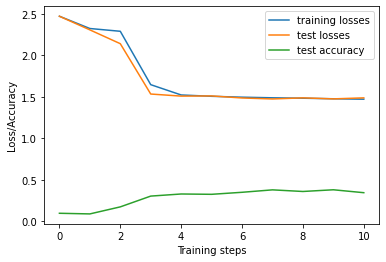

In [11]:
# Visualisations

import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training losses","test losses", "test accuracy"))
plt.show()